In [1]:
from glob import glob
from copy import deepcopy

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.time import Time
from astropy.constants import R_sun, R_jup, M_sun, G
import astropy.units as u
from astropy.table import Table

from celerite import GP, terms, modeling
from batman import TransitParams, TransitModel
from scipy.optimize import minimize
from fleck import Star

In [21]:
lc_paths = glob('data/aumic_b_visit*.csv')#[::2]

In [22]:
class LightCurve(object): 
    def __init__(self, t, f, e): 
        self.time = t
        self.flux = f
        self.err = e
        
    @classmethod
    def from_csv(cls, lc_path):
        table = Table.read(lc_path, format='csv', 
                           header_start=4, data_start=5)
        t = Time(table['BMJD (BJD - 2400000.5d0)'].data + 
                 2400000.5, format='jd')
        f = table['Corrected Flux (Jy)'].data
        e = table['Corrected Uncertainty (Jy)'].data
        return cls(t[~np.isnan(f)], 
                   f[~np.isnan(f)] / np.median(f[~np.isnan(f)]), 
                   e[~np.isnan(f)] / np.median(f[~np.isnan(f)]))

In [127]:
p = TransitParams()

R_star = 0.84 * R_sun  # wikipedia
M_star = 0.31 * M_sun  # wikipedia

init_depth = float(0.4 * R_jup / R_star)**2   # Spitzer proposal
init_inc = 87.95  # manual retrieval
init_t0 = 2458736.6155799085  # manual retrieval
init_lon = -30
init_contrast = 5

inc_stellar = 90 * u.deg
time_ref = 2458525.118161289

p.per = 17.6308
p.t0 = 2458736.6155799085

p.rp = float(0.4 * R_jup / R_star)  # Spitzer proposal
p.inc = 87.9
p.u = [0, 0]
p.limb_dark = 'quadratic'
p.w = 90
p.a = float(((G * M_star) / (4 * np.pi**2) * 
             (p.per * u.day)**2)**(1/3) / R_star)
p.ecc = 0
p.lam = 0

In [144]:
transit_model_kwargs = dict(supersample_factor=3, 
                            exp_time=1/60/24)

class MeanModel(modeling.Model):
    parameter_names = ("depth", "t0", "inc")

    def get_value(self, t):
        trial_p = deepcopy(p)
        trial_p.rp = self.depth**0.5
        trial_p.t0 = self.t0
        trial_p.inc = self.inc
        return TransitModel(trial_p, t, 
                            **transit_model_kwargs
                            ).light_curve(trial_p)

class MeanModelSpots(modeling.Model):
    parameter_names = ("depth", "t0", "inc", "lon", "contrast")

    def get_value(self, t):
        trial_p = deepcopy(p)
        trial_p.rp = self.depth**0.5
        trial_p.t0 = self.t0
        trial_p.inc = self.inc
        lon = [[self.lon]] * u.deg
        lat = [[-55]] * u.deg
        rad = np.array([[0.1]])
        star = Star(spot_contrast=self.contrast, u_ld=[0, 0], 
                    rotation_period=4.865)
        return star.light_curve(lon, lat, rad, inc_stellar, 
                                fast=True, planet=trial_p, 
                                times=t, time_ref=time_ref)[:, 0]

soln [ 2.45902172e-03  2.45873661e+06  8.79445119e+01 -3.00005573e+01
  1.50104857e+00]


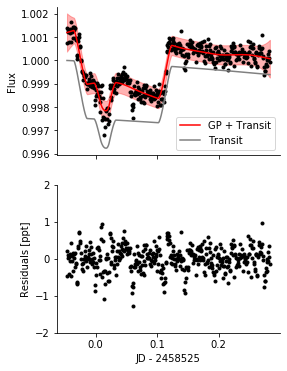

soln [ 2.63405587e-03  2.45873591e+06  8.79876329e+01 -3.00000000e+01
  1.50000000e+00]


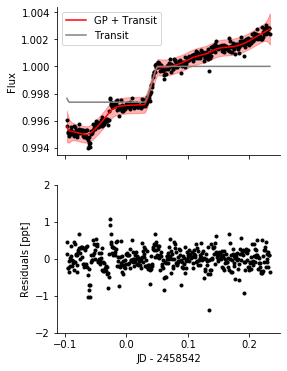

soln [ 2.63405587e-03  2.45873661e+06  8.79214122e+01 -3.00000000e+01
  1.50000000e+00]


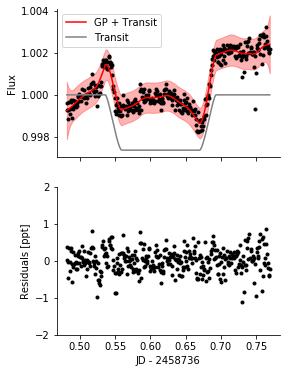

In [147]:
lcs = []

log_rhos = [2.5, 1.5, 1]
t0_offsets = [0, -0.7, 0]
locs = ['lower right', 'upper left', 'upper left']
contrasts = [1.5, 1.5, 1.5]

for i, lc_path in enumerate(lc_paths): 
    lc = LightCurve.from_csv(lc_path)
    lcs.append(lc)

    bounds = dict(depth=[0.9 * init_depth, 1.1 * init_depth], 
                  t0=[init_t0 - 0.05 + t0_offsets[i], init_t0 + 0.05 + t0_offsets[i]],
                  inc=[87.5, 88.9], 
                  contrast=[1, 10],
                  lon=[-90, 90])
    
    gp = GP(terms.Matern32Term(log_sigma=1, log_rho=log_rhos[i]),
#             mean=MeanModel(depth=init_depth, t0=init_t0 + t0_offsets[i], inc=init_inc,
#                            bounds=bounds), 
            mean=MeanModelSpots(depth=init_depth, t0=init_t0 + t0_offsets[i], 
                                inc=init_inc, lon=init_lon, 
                                contrast=contrasts[i], 
                                bounds=bounds), 
            fit_mean=True)
    gp.kernel.freeze_parameter('log_sigma')
    gp.kernel.freeze_parameter('log_rho')
    
    gp.compute(lc.time.jd, lc.err)
    
    # Plot initial model
#     plt.plot(lc.time.jd, lc.flux, '.')
#     plt.plot(lc.time.jd, gp.mean.get_value(lc.time.jd))
#     plt.show()
    
    
    # Define a cost function
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    # Fit for the maximum likelihood parameters
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(neg_log_like, initial_params,
                    method="L-BFGS-B", bounds=bounds, 
                    args=(lc.flux, gp))
    
    gp.set_parameter_vector(soln.x)
    print('soln', soln.x)
    soln_transit_params = soln.x[2:]
    soln_transit = gp.mean.get_value(lc.time.jd)
    
    model, var = gp.predict(lc.flux, return_var=True)
    std = np.sqrt(var)
    
    fig, ax = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
    
    bjd_offset = int(lc.time.jd.mean())
    ax[0].plot(lc.time.jd - bjd_offset, lc.flux, '.', color='k')
    
    ax[0].plot(lc.time.jd - bjd_offset, model, 
               color='r', label='GP + Transit')
    ax[0].fill_between(lc.time.jd - bjd_offset, 
                       model - std, model + std, 
                       color='r', alpha=0.3, zorder=-10)

    ax[0].plot(lc.time.jd - bjd_offset, soln_transit / soln_transit.max(), 
               color='gray', label='Transit')
    
    ax[1].plot(lc.time.jd - bjd_offset, (lc.flux - model) * 1e3, 'k.')
    
    ax[1].set(xlabel=f"JD - {bjd_offset:d}", ylabel='Residuals [ppt]')
    ax[0].legend(loc=locs[i])
    ax[0].set_ylabel('Flux')
    
    for axis in ax: 
        for sp in ['right', 'top']: 
            axis.spines[sp].set_visible(False)
    ax[1].set_ylim([-2, 2])
    
    fig.savefig(f'plots/lc_{i}.pdf', bbox_inches='tight')
    plt.show()